## Image Classification using 2-Layer Neural Network

In [1]:
import time
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

np.random.seed(1)

In [2]:
def load_data():
    train_dataset = h5py.File('datasets/train_catvnoncat.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File('datasets/test_catvnoncat.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

In [3]:
train_x_orig, train_y, test_x_orig, test_y, classes = load_data()

y = 0. It's a non-cat picture.


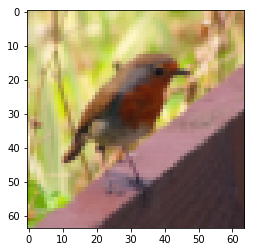

In [4]:
# Example of a picture
index = 10
plt.imshow(train_x_orig[index])
print ("y = " + str(train_y[0,index]) + ". It's a " + classes[train_y[0,index]].decode("utf-8") +  " picture.")

In [5]:
# Explore your dataset 
m_train = train_x_orig.shape[0]
num_px = train_x_orig.shape[1]
m_test = test_x_orig.shape[0]

print ("Number of training examples: " + str(m_train))
print ("Number of testing examples: " + str(m_test))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_x_orig shape: " + str(train_x_orig.shape))
print ("train_y shape: " + str(train_y.shape))
print ("test_x_orig shape: " + str(test_x_orig.shape))
print ("test_y shape: " + str(test_y.shape))

Number of training examples: 209
Number of testing examples: 50
Each image is of size: (64, 64, 3)
train_x_orig shape: (209, 64, 64, 3)
train_y shape: (1, 209)
test_x_orig shape: (50, 64, 64, 3)
test_y shape: (1, 50)


In [6]:
# Reshape the training and test examples 
train_x_flatten = train_x_orig.reshape(train_x_orig.shape[0], -1).T   # The "-1" makes reshape flatten the remaining dimensions
test_x_flatten = test_x_orig.reshape(test_x_orig.shape[0], -1).T

# Standardize data to have feature values between 0 and 1.
train_x = train_x_flatten/255.
test_x = test_x_flatten/255.

print ("train_x's shape: " + str(train_x.shape))
print ("test_x's shape: " + str(test_x.shape))

train_x's shape: (12288, 209)
test_x's shape: (12288, 50)


In [7]:
### CONSTANTS DEFINING THE MODEL ####
n_x = 12288     # num_px * num_px * 3
n_h = 7         #number of hidden units
n_y = 1         #number of output units

layers_dims = (n_x, n_h, n_y)

In [8]:
def sigmoid(Z):
       
    A = 1/(1+np.exp(-Z))   
    return A

In [9]:
def relu(Z):
        
    A = np.maximum(0,Z)
    return A


In [10]:
def relu_differentiated(dA, Z):       
    
    dZ = np.array(dA, copy=True) # just converting dz to a correct object.
    
    # When z <= 0, you should set dz to 0 as well. 
    dZ[Z <= 0] = 0
        
    return dZ

In [15]:
def sigmoid_differentiated(dA, Z):
   
    s = 1/(1+np.exp(-Z))
    dZ = dA * s * (1-s)
        
    return dZ

In [19]:
def two_lyr_nn_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost=False):
    
    np.random.seed(1)
    
    costs = []                              # to keep track of the cost
    m = X.shape[1]                           # number of examples
    (n_x, n_h, n_y) = layers_dims            #constants in the model
    
    #initialize parameters
    W1 = np.random.randn(n_h, n_x)*0.01
    b1 = np.zeros((n_h, 1))
    W2 = np.random.randn(n_y, n_h)*0.01
    b2 = np.zeros((n_y, 1))
    
    for i in range(0, num_iterations):
        
        #forward propagation
        Z1 = np.dot(W1, X)+b1
        A1 = relu(Z1)
        Z2 = np.dot(W2, A1)+b2
        A2 = sigmoid(Z2)
        
        #cost computation        
        cost = -(1/m)*np.sum(np.multiply(np.log(A2), Y) + np.multiply(np.log(1-A2),(1-Y)))
        
        #backward propagation
        
        # Initializing backward propagation
        dA2 = - (np.divide(Y, A2) - np.divide(1 - Y, 1 - A2))
        
        dZ2 = sigmoid_differentiated(dA2, Z2)
        dW2 = (1/m)*np.dot(dZ2, A1.T)
        db2 = (1/m)*np.sum(dZ2, axis=1, keepdims=True)
        
        dA1 = np.dot(W2.T, dZ2)
        
        dZ1 = relu_differentiated(dA1, Z1)
        dW1 = (1/m)*np.dot(dZ1, X.T)
        db1 = (1/m)*np.sum(dZ1, axis=1, keepdims=True)
        
        #update parameters
        W1 = W1 - learning_rate*dW1
        b1 = b1 - learning_rate*db1
        W2 = W2 - learning_rate*dW2
        b2 = b2 - learning_rate*db2
        
        # Print the cost every 100 training example
        if print_cost and i % 100 == 0:
            print("Cost after iteration {}: {}".format(i, np.squeeze(cost)))
        if print_cost and i % 100 == 0:
            costs.append(cost)
            
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    parameters = {"W1": W1, "b1":b1, "W2":W2, "b2":b2}
    
    return parameters
        
        
        
    
    
    

In [20]:
def predict(X, y, parameters):
        
    m = X.shape[1]
    n = len(parameters) // 2 # number of layers in the neural network
    p = np.zeros((1,m))
    
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    
    # Forward propagation
    Z1 = np.dot(W1, X)+b1
    A1 = relu(Z1)
    Z2 = np.dot(W2, A1)+b2
    A2 = sigmoid(Z2)

    # convert probas to 0/1 predictions
    for i in range(0, A2.shape[1]):
        if A2[0,i] > 0.5:
            p[0,i] = 1
        else:
            p[0,i] = 0
    
    #print results
    #print ("predictions: " + str(p))
    #print ("true labels: " + str(y))
    print("Accuracy: "  + str(np.sum((p == y)/m)))
        
    return p

Cost after iteration 0: 0.693049735659989
Cost after iteration 100: 0.6464320953428849
Cost after iteration 200: 0.6325140647912677
Cost after iteration 300: 0.6015024920354665
Cost after iteration 400: 0.5601966311605747
Cost after iteration 500: 0.515830477276473
Cost after iteration 600: 0.47549013139433266
Cost after iteration 700: 0.4339163151225749
Cost after iteration 800: 0.400797753620389
Cost after iteration 900: 0.35807050113237987
Cost after iteration 1000: 0.3394281538366412
Cost after iteration 1100: 0.30527536361962637
Cost after iteration 1200: 0.27491377282130186
Cost after iteration 1300: 0.2468176821061485
Cost after iteration 1400: 0.19850735037466086
Cost after iteration 1500: 0.17448318112556657
Cost after iteration 1600: 0.17080762978096237
Cost after iteration 1700: 0.11306524562164721
Cost after iteration 1800: 0.09629426845937147
Cost after iteration 1900: 0.08342617959726858
Cost after iteration 2000: 0.07439078704319078
Cost after iteration 2100: 0.066307481

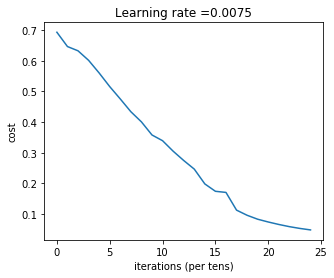

In [21]:
parameters = two_lyr_nn_model(train_x, train_y, layers_dims, num_iterations = 2500, print_cost = True)

In [22]:
pred_train = predict(train_x, train_y, parameters)

Accuracy: 1.0


In [23]:
pred_test = predict(test_x, test_y, parameters)

Accuracy: 0.72


In [24]:
def print_mislabeled_images(classes, X, y, p):
    """
    Plots images where predictions and truth were different.
    X -- dataset
    y -- true labels
    p -- predictions
    """
    a = p + y
    mislabeled_indices = np.asarray(np.where(a == 1))
    plt.rcParams['figure.figsize'] = (40.0, 40.0) # set default size of plots
    num_images = len(mislabeled_indices[0])
    for i in range(num_images):
        index = mislabeled_indices[1][i]
        
        plt.subplot(2, num_images, i + 1)
        plt.imshow(X[:,index].reshape(64,64,3), interpolation='nearest')
        plt.axis('off')
        plt.title("Prediction: " + classes[int(p[0,index])].decode("utf-8") + " \n Class: " + classes[y[0,index]].decode("utf-8"))


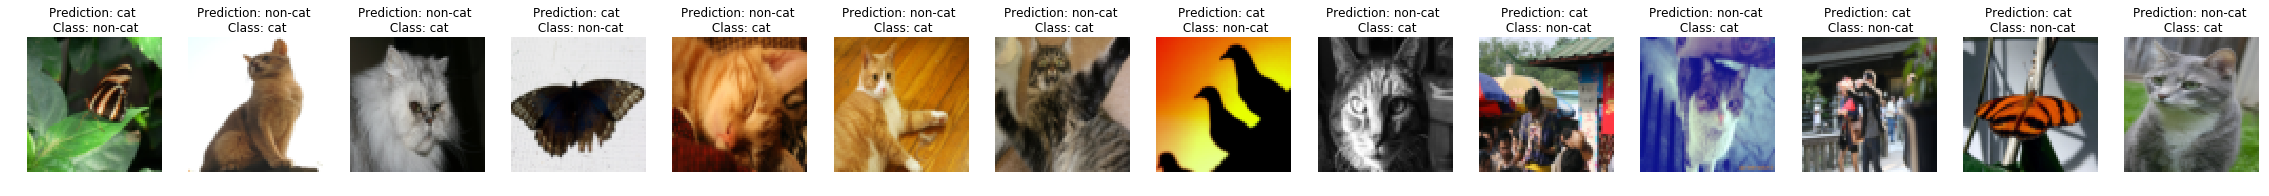

In [25]:
print_mislabeled_images(classes, test_x, test_y, pred_test)